In [1]:
import pylab as pl
from scipy.optimize import minimize

from utils import *
from grm_utils import *

In [3]:
# -----------------------------------------------------------
# step 1: read catalogues
xmm12_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_12/XMMLSS_12_1538856059_1539286252_pol_detections.fits'
xmm12c = SkyCoord(34.4625,-4.83306,unit="deg")
xmm12 = read_catalogue(xmm12_file, xmm12c)

xmm13_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_13/XMMLSS_13_1538942495_1539372679_pol_detections.fits'
xmm13c = SkyCoord(35.175,-4.83306,unit="deg")
xmm13 = read_catalogue(xmm13_file, xmm13c)

xmm14_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_14/XMMLSS_14_1539028868_1539460932_pol_detections.fits'
xmm14c = SkyCoord(35.84167,-4.83306,unit="deg")
xmm14 = read_catalogue(xmm14_file, xmm14c)

cosmos_file = '/Users/ascaife/DATA/MIGHTEE/catalog/COSMOS/COSMOS_1587911796_1524147354_1525613583_pol_detections.fits'
cosmosc = SkyCoord(35.84167,-4.83306,unit="deg") # update this
cosmos = read_catalogue(cosmos_file, cosmosc)

In [4]:
# step 2: merge catalogues
mightee = merge_cats([xmm12, xmm13, xmm14, cosmos])
print('# of sources: {}'.format(mightee.shape[0]))

Found 24 matches
# of sources: 418


In [5]:
# -----------------------------------------------------------
# step 2a: Russ' filter to remove XMMLSS filament:
polflux_limit = 70.0; frac_p_limit = 30.0
idx = mightee[(mightee['pol'] < polflux_limit) & (mightee['P/I'] > frac_p_limit)].index
mightee = mightee.drop(index = idx)
print('# of sources in filtered catalogue: {}'.format(mightee.shape[0]))

# of sources in filtered catalogue: 353


In [6]:
# step 3: redshift and galactic latitude filtering
mightee = filter_z(mightee, has_z=True, spec_z=False)
print('# of sources (after z filter): {}'.format(mightee.shape[0]))

# add columns for (l,b)
mightee['l'], mightee['b'] = j2000_to_gal(mightee['ra'].values, mightee['dec'].values)

# filter b<25:
mightee = filter_glat(mightee, bmin=25.)
print('# of sources (after b filter): {}'.format(mightee.shape[0]))

# step 4: get GRMs
ra = np.array(mightee['ra'].values)
dec= np.array(mightee['dec'].values)

fitsfile = './faradaysky/faraday2020v2.fits'
grmdata, grmhp = get_grm_data(fitsfile) # from grm_utils.py

# nearest pixel values:
grm_fs, grm_fs_std = get_grm(ra, dec, grmdata, grmhp) # from grm_utils.py
mightee['GRM_FS'] = grm_fs
mightee['GRM_FSerr'] = grm_fs_std

# 1 degree median values:
grm1_med, grm1_mad, grm1_std = get_grm1(ra, dec, grmdata, grmhp, r=0.5) # 1 degree median values (grm_utils)
mightee['GRM1'] = grm1_med
mightee['GRM1err'] = grm1_mad

# of sources (after z filter): 238
# of sources (after b filter): 238


In [7]:
def bin_rrm(rrm, bins, idx_bin, n_bin):
    
    sig_rrm= [np.std(rrm[idx_bin == j]) for j in range(1, len(bins))]
    ste_sig = standard_error_on_stdev(sig_rrm, n_bin)

    return sig_rrm, ste_sig

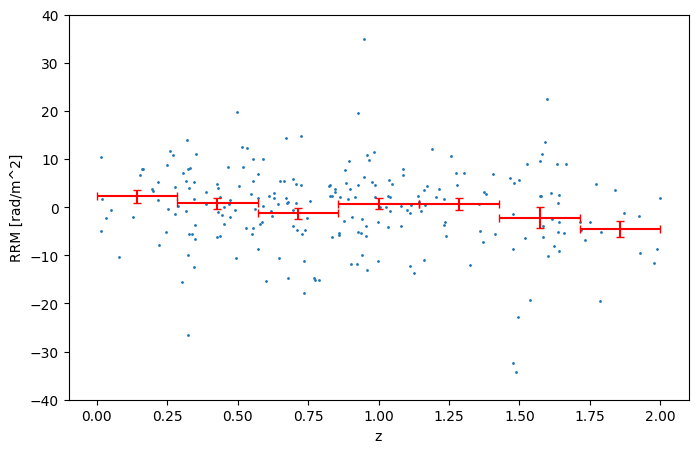

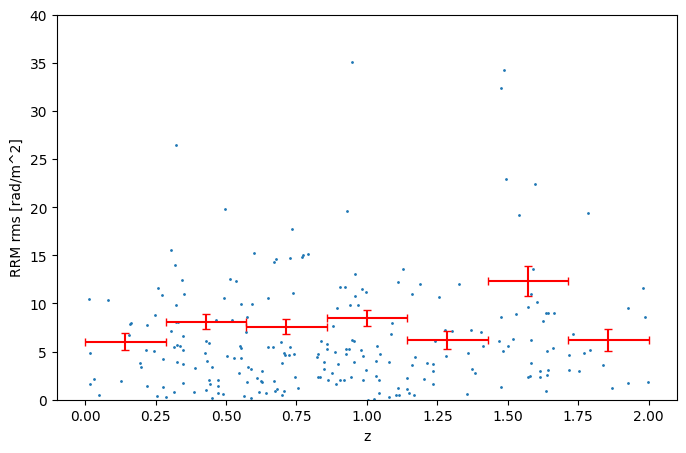

In [8]:
# step 7: redshift binning
rm      = mightee['RM'].values
rm_err  = mightee['RM_err'].values
grm     = mightee['GRM_FS'].values      # use 1 deg median
grm_err = mightee['GRM_FSerr'].values   # use 1 deg median
grm1    = mightee['GRM1'].values        # use 1 deg median
z       = mightee['best_z'].values

rrm = rm - grm1

std = np.std(rrm)
z = z[np.where(np.abs(rrm)<=2*std)]
rrm = rrm[np.where(np.abs(rrm)<=2*std)]

bins, idx_bin, n_bin = bin_z(z, nbins=7)
mu_bin = 0.5*np.diff(bins)+bins[:-1]

mu_rrm = [np.average(rrm[idx_bin == j]) for j in range(1, len(bins))]
sig_rrm= [np.std(rrm[idx_bin == j]) for j in range(1, len(bins))]
ste_rrm= sig_rrm/np.sqrt(n_bin)
ste_sig = standard_error_on_stdev(sig_rrm, n_bin)

pl.rcParams["figure.figsize"] = (8,5)
pl.scatter(z, rrm, s=1)
pl.errorbar(mu_bin, mu_rrm, yerr=ste_rrm, xerr=0.5*np.diff(bins), c='red', ls='', capsize=3.)
pl.xlabel('z')
pl.ylabel('RRM [rad/m^2]')
pl.ylim(-40,40)
pl.savefig('./plots/mightee_rrm_z.png')
pl.show()

pl.scatter(z, np.abs(rrm), s=1)
pl.errorbar(mu_bin, sig_rrm, yerr=ste_sig, xerr=0.5*np.diff(bins), c='red', ls='', capsize=3.)
pl.xlabel('z')
pl.ylabel('RRM rms [rad/m^2]')
pl.ylim(0,40)
pl.savefig('./plots/mightee_rrmrms_z.png')
pl.show()

In [9]:
print(np.array(mu_rrm)/np.array(ste_rrm))

[ 1.75221564  0.71214369 -1.1240811   0.648176    0.55657275 -0.97282368
 -2.78036802]


In [10]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0., 10., 1.]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(mu_bin, sig_rrm, ste_sig))
m_ml, b_ml, log_f_ml = soln.x
ih = soln.hess_inv

print("Maximum likelihood estimates:")
print("m = {:.3f}+/-{:.3f}".format(m_ml, np.sqrt(ih[0,0])))
print("b = {:.3f}+/-{:.3f}".format(b_ml, np.sqrt(ih[1,1])))
print("f = {:.3f}+/-{:.3f}".format(np.exp(log_f_ml), np.sqrt(ih[2,2])))

Maximum likelihood estimates:
m = 0.965+/-1.232
b = 6.739+/-1.199
f = 0.156+/-0.553


In [11]:
def zdep(rrm, z, model='C1'):
    
    if model=='C1':
        rrm0 = rrm*(1+z)**2
    elif model=='C2':
        rrm0 = rrm*((1+z)**3-1)
        rrm0/= 3*z
    elif model=='C3':
        rrm0 = rrm*(1+z)
    
    return rrm0

In [12]:
df = pd.DataFrame(mu_bin, columns=["z"])
df["n_src"] = n_bin
df["RRM mean"] = mu_rrm
df["RRM ste"] = ste_rrm
df["RRM rms"] = sig_rrm
df["RRM sig"] = ste_sig

rrm0 = zdep(rrm, z, model='C1')
df["C1 rms"], df["C1 sig"] = bin_rrm(rrm0, bins, idx_bin, n_bin)

rrm0 = zdep(rrm, z, model='C2')
df["C2 rms"], df["C2 sig"] = bin_rrm(rrm0, bins, idx_bin, n_bin)

rrm0 = zdep(rrm, z, model='C3')
df["C3 rms"], df["C3 sig"] = bin_rrm(rrm0, bins, idx_bin, n_bin)

In [13]:
df.head(10)

,z,n_src,RRM mean,RRM ste,RRM rms,RRM sig,C1 rms,C1 sig,C2 rms,C2 sig,C3 rms,C3 sig
0,0.142857,22,2.255780,1.287387,6.038381,0.910320,8.412310,1.268203,7.163424,1.079927,7.083701,1.067908
1,0.428571,49,0.826212,1.160175,8.121227,0.820368,16.106224,1.626974,11.855551,1.197591,11.387146,1.150275
2,0.714286,45,-1.274224,1.133569,7.604212,0.801554,22.315273,2.352236,14.301546,1.507515,13.005444,1.370894
3,1.000000,51,0.768825,1.186136,8.470706,0.838725,32.840658,3.251710,19.318514,1.912818,16.660879,1.649673
4,1.285714,24,0.705494,1.267568,6.209789,0.896306,32.085654,4.631165,17.459344,2.520039,14.098116,2.034888
5,1.571429,31,-2.156969,2.217225,12.344988,1.567815,79.008838,10.034132,40.851905,5.188197,31.215340,3.964352
6,1.857143,14,-4.608373,1.657469,6.201679,1.172007,50.385907,9.522041,24.738345,4.675108,17.653446,3.336188


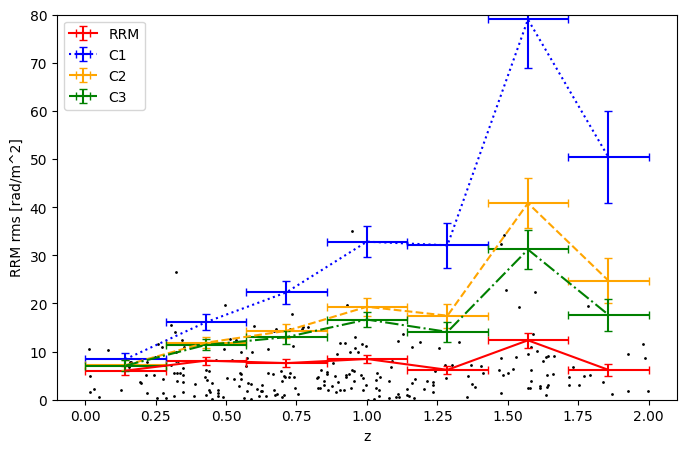

In [14]:
pl.scatter(z, np.abs(rrm), c='black', s=1)
pl.errorbar(mu_bin, sig_rrm, yerr=ste_sig, xerr=0.5*np.diff(bins), c='red', ls='-', capsize=3., label='RRM')
pl.errorbar(mu_bin, df["C1 rms"].values, yerr=df["C1 sig"].values, xerr=0.5*np.diff(bins), c='blue', ls='dotted', capsize=3., label='C1')
pl.errorbar(mu_bin, df["C2 rms"].values, yerr=df["C2 sig"].values, xerr=0.5*np.diff(bins), c='orange', ls='dashed', capsize=3., label='C2')
pl.errorbar(mu_bin, df["C3 rms"].values, yerr=df["C3 sig"].values, xerr=0.5*np.diff(bins), c='green', ls='dashdot', capsize=3., label='C3')
pl.xlabel('z')
pl.ylabel('RRM rms [rad/m^2]')
pl.ylim(0,80)
pl.legend()
pl.savefig('./plots/mightee_cmods.png')
pl.show()

In [15]:
# C1 evolution fit:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0., 10., 1.]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(mu_bin, df["C1 rms"].values, df["C1 sig"].values))
m_ml, b_ml, log_f_ml = soln.x
ih = soln.hess_inv

print("Maximum likelihood estimates:")
print("m = {:.3f}+/-{:.3f}".format(m_ml, np.sqrt(ih[0,0])))
print("b = {:.3f}+/-{:.3f}".format(b_ml, np.sqrt(ih[1,1])))
print("f = {:.3f}+/-{:.3f}".format(np.exp(log_f_ml), np.sqrt(ih[2,2])))

Maximum likelihood estimates:
m = 26.990+/-2.505
b = 4.391+/-1.334
f = 0.000+/-263.911


In [16]:
# C2 evolution fit:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0., 10., 1.]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(mu_bin, df["C2 rms"].values, df["C2 sig"].values))
m_ml, b_ml, log_f_ml = soln.x
ih = soln.hess_inv

print("Maximum likelihood estimates:")
print("m = {:.3f}+/-{:.3f}".format(m_ml, np.sqrt(ih[0,0])))
print("b = {:.3f}+/-{:.3f}".format(b_ml, np.sqrt(ih[1,1])))
print("f = {:.3f}+/-{:.3f}".format(np.exp(log_f_ml), np.sqrt(ih[2,2])))

Maximum likelihood estimates:
m = 13.119+/-2.258
b = 5.429+/-1.416
f = 0.097+/-1.129


In [17]:
# C3 evolution fit:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0., 10., 1.]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(mu_bin, df["C3 rms"].values, df["C3 sig"].values))
m_ml, b_ml, log_f_ml = soln.x
ih = soln.hess_inv

print("Maximum likelihood estimates:")
print("m = {:.3f}+/-{:.3f}".format(m_ml, np.sqrt(ih[0,0])))
print("b = {:.3f}+/-{:.3f}".format(b_ml, np.sqrt(ih[1,1])))
print("f = {:.3f}+/-{:.3f}".format(np.exp(log_f_ml), np.sqrt(ih[2,2])))

Maximum likelihood estimates:
m = 9.316+/-2.070
b = 6.232+/-1.518
f = 0.134+/-0.640


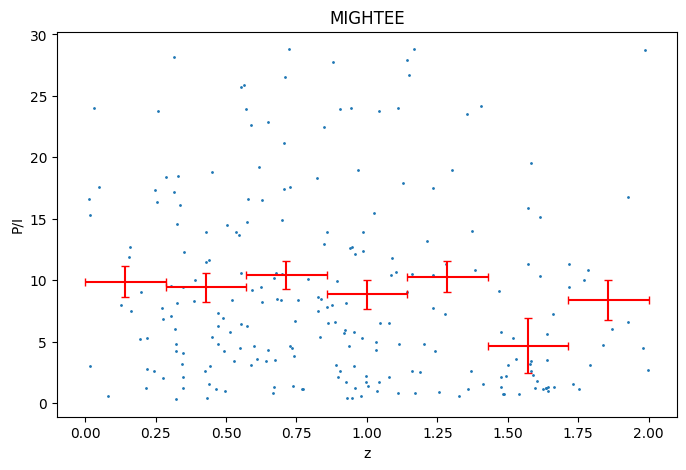

In [18]:
# step 7: redshift binning
rm      = mightee['RM'].values
rm_err  = mightee['RM_err'].values
grm1    = mightee['GRM1'].values        # use 1 deg median
z       = mightee['best_z'].values
pfrac   = mightee['P/I'].values

rrm = rm - grm1

std = np.std(rrm)
z = z[np.where(np.abs(rrm)<=2*std)]
pfrac = pfrac[np.where(np.abs(rrm)<=2*std)]

bins, idx_bin, n_bin = bin_z(z, nbins=7)
mu_bin = 0.5*np.diff(bins)+bins[:-1]

mu_pf = [np.average(pfrac[idx_bin == j]) for j in range(1, len(bins))]
sig_pf= [np.std(pfrac[idx_bin == j]) for j in range(1, len(bins))]
ste_pf= sig_rrm/np.sqrt(n_bin)
ste_sig = standard_error_on_stdev(sig_rrm, n_bin)

pl.rcParams["figure.figsize"] = (8,5)
pl.scatter(z, pfrac, s=1)
pl.errorbar(mu_bin, mu_pf, yerr=ste_pf, xerr=0.5*np.diff(bins), c='red', ls='', capsize=3.)
pl.xlabel('z')
pl.ylabel('P/I')
pl.title('MIGHTEE')
pl.savefig('./plots/mightee_pfracz.png')
pl.show()